In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from statsmodels.tsa.statespace.sarimax import SARIMAX

from offline_ts import SARMAPrediction
from online_ts import SARMA_OGD
from utils import rmse, mape

In [2]:
def generate_sarma(phi, Phi, theta, Theta, sigma, s, n_samples):
    p = len(phi)
    P = len(Phi)
    q = len(theta)
    Q = len(Theta)
    generator = SARMAPrediction(phi, Phi, theta, Theta, s)
    
    series = np.random.uniform(-1, 1, (p + P * s,)).tolist() # [0] * (p + P * s) 
    noises = np.random.normal(0, sigma, (p + P * s,)).tolist() # [0] * (q + Q * s)
    for i in range(n_samples):
        noise = np.random.normal(0, sigma)
        x = generator.predict(series[:-(p + P * s + 1):-1], noises[:-(q + Q * s + 1):-1])
        x += noise
        
        series.append(x)
        noises.append(noise)
    return np.array(series[p + P * s:]), np.array(noises[q + Q * s:])

In [3]:
phi = np.array([0.3])
Phi = np.array([-0.5])
theta = np.array([0.6])
Theta = np.array([0.2])
sigma = 0.5
s = 12
n_samples = 5000

series, noises = generate_sarma(phi, Phi, theta, Theta, sigma, s, n_samples)

In [4]:
p = len(phi)
q = len(theta)
P = len(Phi)
Q = len(Theta)

offline_forecasts = series - noises

In [5]:
offline_losses = noises**2
offline_cumulative_losses = np.cumsum(offline_losses)

In [6]:
p_online = 2
P_online = 2
X_max = np.max(np.abs(series))
model = SARMA_OGD(p_online, P_online, s, X_max)

online_forecasts = []
online_losses = []

for x in series:
    # fit model
    x_pred, loss = model.fit_one_step(x)
    
    online_forecasts.append(x_pred)
    online_losses.append(loss)

online_cumulative_losses = np.cumsum(online_losses)

## Main plot

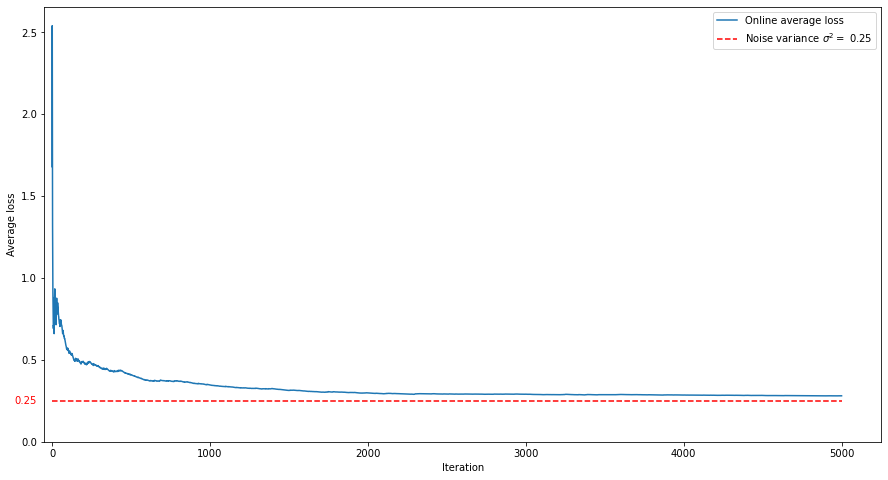

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hlines(y=sigma**2, xmin=0, xmax=n_samples, color='r', linestyle='--', 
          label=r'Noise variance $\sigma ^ 2 = $ {}'.format(sigma**2))
ax.plot((online_cumulative_losses / np.arange(1, n_samples + 1)), label='Online average loss')

trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, sigma**2, "{}".format(sigma**2), color="red", transform=trans, 
        ha="right", va="center")

plt.xlabel('Iteration')
plt.ylabel('Average loss')
ax.set_xlim(xmin=-50)
ax.set_ylim(ymin=0)
plt.legend()
plt.show()

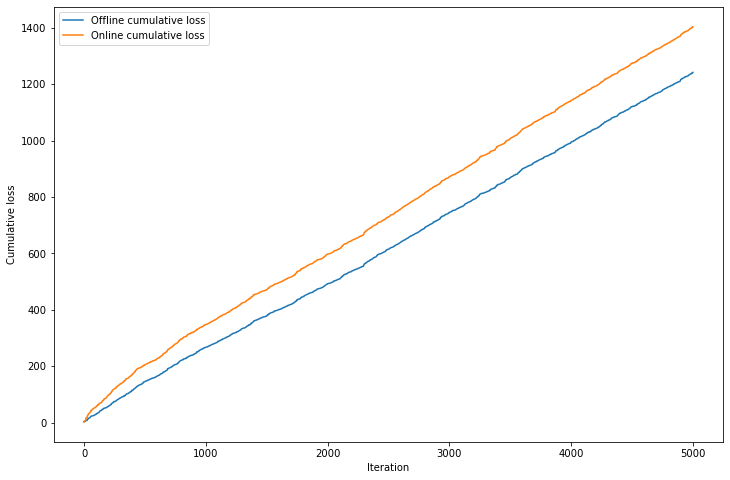

In [8]:
plt.figure(figsize=(12,8))
plt.plot(offline_cumulative_losses, label='Offline cumulative loss')
plt.plot(online_cumulative_losses, label='Online cumulative loss')
plt.xlabel('Iteration')
plt.ylabel('Cumulative loss')
plt.legend()
plt.show()

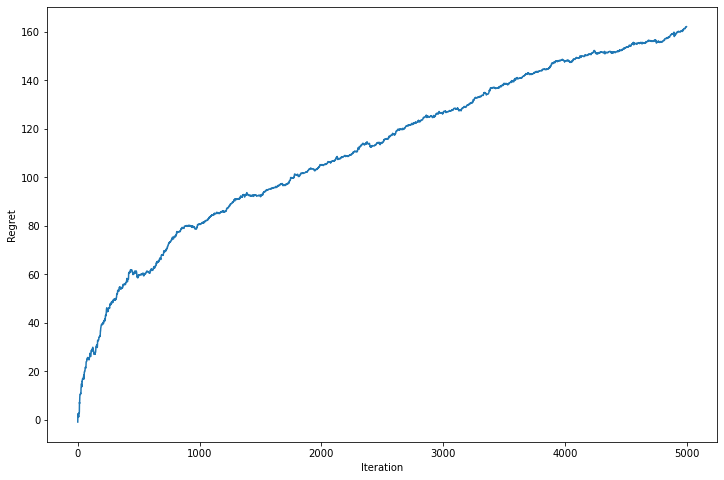

In [9]:
plt.figure(figsize=(12,8))
plt.plot(online_cumulative_losses - offline_cumulative_losses)
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.show()

## Optional plot

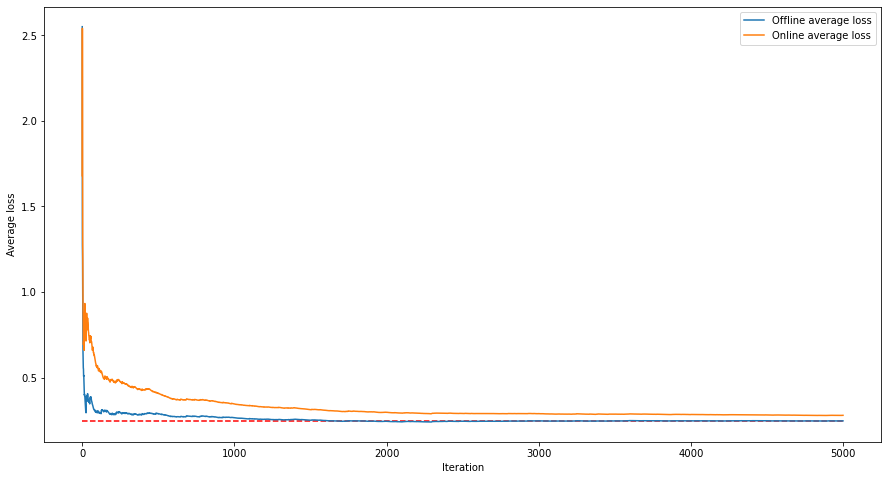

In [10]:
plt.figure(figsize=(15,8))
plt.hlines(y=sigma**2, xmin=0, xmax=n_samples, color='r', linestyle='--')
plt.plot((offline_cumulative_losses / np.arange(1, n_samples + 1)), label='Offline average loss')
plt.plot((online_cumulative_losses / np.arange(1, n_samples + 1)), label='Online average loss')
plt.xlabel('Iteration')
plt.ylabel('Average loss')
plt.legend()
plt.show()

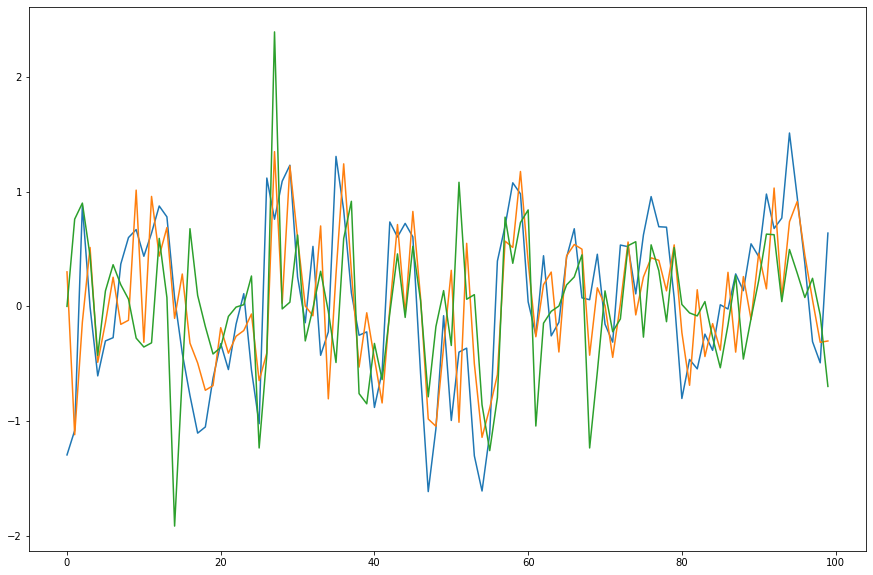

In [11]:
plt.figure(figsize=(15,10))
plt.plot(series[:100])
plt.plot(offline_forecasts[:100])
plt.plot(online_forecasts[:100])
plt.show()

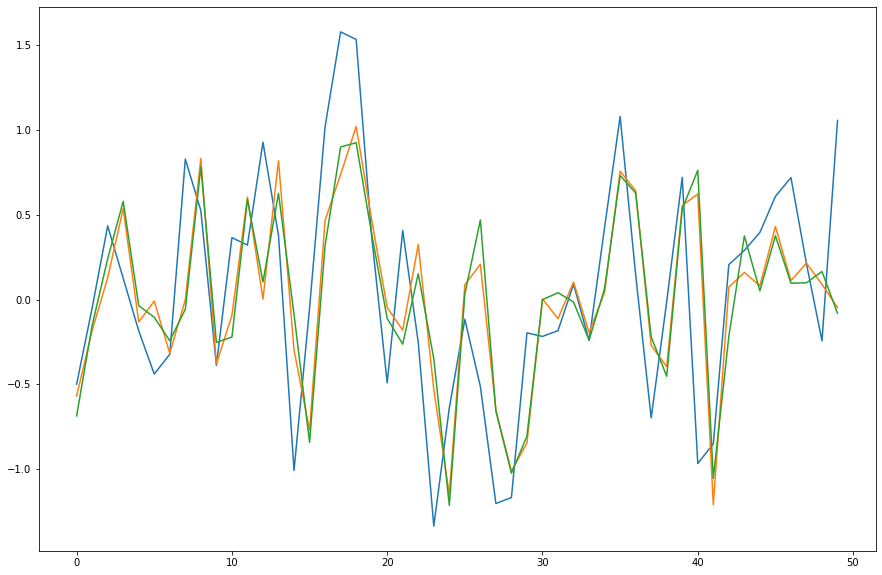

In [12]:
plt.figure(figsize=(15,10))
plt.plot(series[-50:])
plt.plot(offline_forecasts[-50:])
plt.plot(online_forecasts[-50:])
plt.show()